In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
%matplotlib inline
import seaborn as sns
sns.set() 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MaxAbsScaler
from sklearn.metrics import accuracy_score
from sklearn.utils.extmath import softmax
from catboost import CatBoostClassifier

train = pd.read_csv('prepared.csv')

## Посмотрим на корреляцию величин

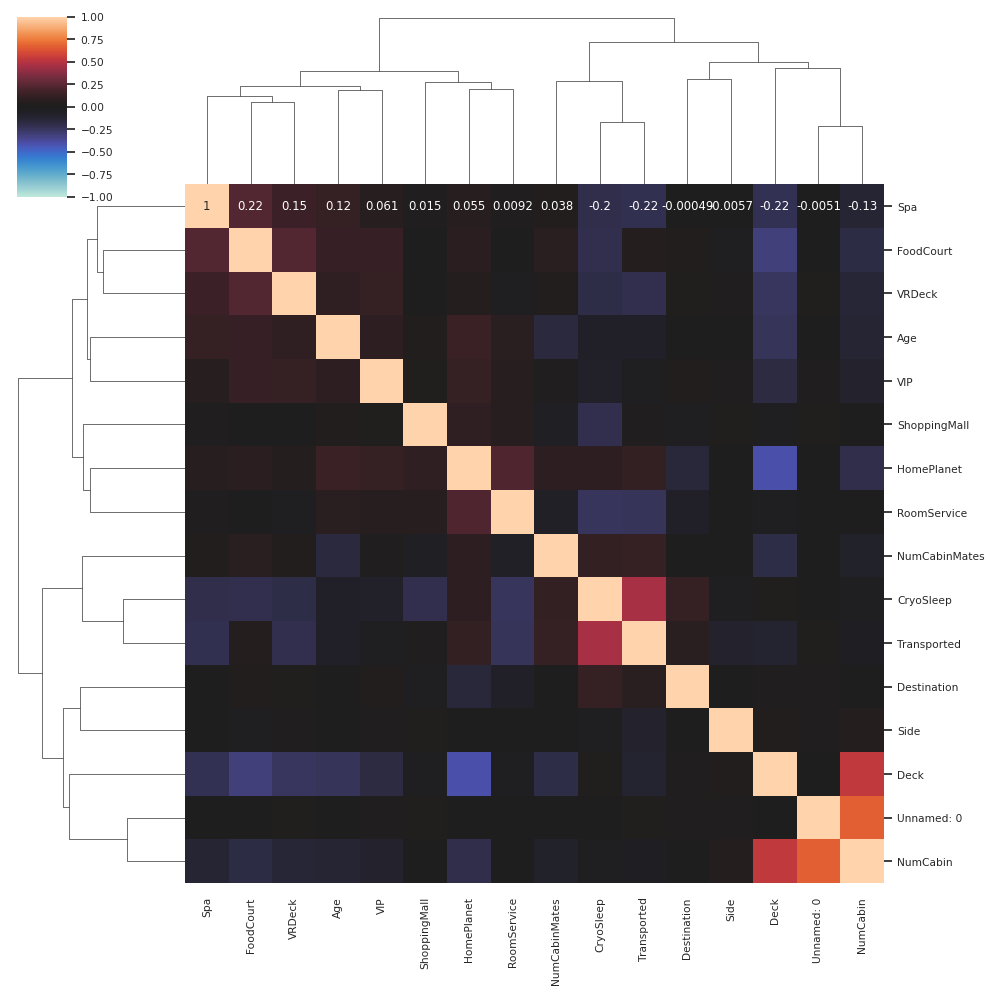

In [2]:
'''
plt.figure(figsize=(15,6))
sns.heatmap(train.corr(), 
            vmin=-1.0,
            vmax=1.0, 
            cmap="icefire",
            square=True,
            annot=True)
'''
sns.set (font_scale=0.7)
sns.clustermap(
        train.corr("pearson"),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=True
    )

Видим, что CryoSleep имеет самую сульную корреляцию к Transported. И видим, что наблюдается обратная корреляция к тратам на различные развлечения и вероятностью транспортировки. Это логично, так как пассажир, который был в состоянии анабиоза в течение транспортировки, не мог тратить денег на дополнительные развлечения.

Из-за неустраняемых выбросов сложно судить о важности RoomService, FoodCourt ShoppingMall, Spa, VRDeck, VIP. Тем не менее, можно сделать вывод, что Spa, VRDeck и RoomService полезны, а FoodCourt, ShoppingMall и VIP менее существенны

# Зависимости между Признаками (Features) и Ответом (Transported)
В этом разделе, мы анализируем зависимости между разными признаками по отношению к Транспортировке(Transported). Мы увидим как разные значения признаков отображают разные шансы на транспортировку. Мы также построим разные виды диаграмм, для того, чтобы представить наши данные и находки.

In [3]:
transported = train[train['Transported'] == True]
not_transported = train[train['Transported'] == False]

print ("transported: %i (%.1f%%)"%(len(transported), (len(transported))/len(train)*100.0))
print ("Not transported: %i (%.1f%%)"%(len(not_transported), (len(not_transported))/len(train)*100.0))
print ("Total: %i"%len(train))

transported: 4378 (50.4%)
Not transported: 4315 (49.6%)
Total: 8693


## CryoSleep vs Transported - Одна из самых показательных фичей
Пассажиры, переведенные в состояние анабиоза на время рейса, имеют гораздо большие шансы на транспортировку.

In [4]:
train.groupby('CryoSleep').Transported.value_counts()

CryoSleep  Transported
False      False          3761
           True           1895
True       True           2483
           False           554
Name: count, dtype: int64

In [5]:
train[['CryoSleep', 'Transported']].groupby('CryoSleep', as_index = False).mean()

,CryoSleep,Transported
0,False,0.335042
1,True,0.817583


/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='CryoSleep', ylabel='Transported'>

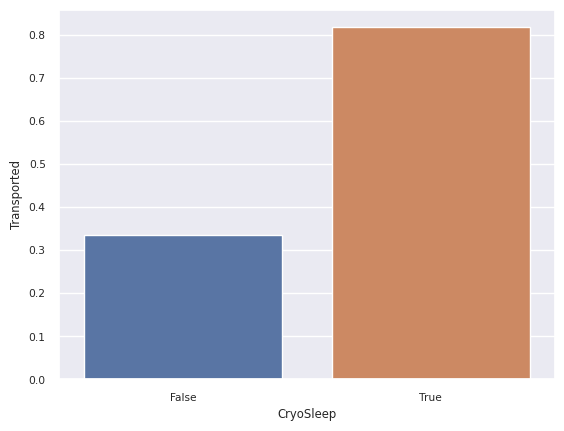

In [6]:
sns.barplot(x='CryoSleep', y='Transported', data=train, errorbar=None)

## NumCabinMates vs Transported
У пассажиров, 3-6 соседей в каюте имеют чуть большие шансы на транспортировку, чем у остальных.

In [7]:
train.NumCabinMates.value_counts()

NumCabinMates
1    5427
2    1372
3     747
4     416
5     235
0     199
6     198
7      91
8       8
Name: count, dtype: int64

In [8]:
train.groupby('NumCabinMates').Transported.value_counts()

NumCabinMates  Transported
0              True            100
               False            99
1              False          3009
               True           2418
2              True            817
               False           555
3              True            457
               False           290
4              True            264
               False           152
5              True            142
               False            93
6              True            125
               False            73
7              True             52
               False            39
8              False             5
               True              3
Name: count, dtype: int64

In [9]:
train[['NumCabinMates', 'Transported']].groupby('NumCabinMates', as_index = False).mean()

,NumCabinMates,Transported
0,0,0.502513
1,1,0.445550
2,2,0.595481
3,3,0.611780
4,4,0.634615
5,5,0.604255
6,6,0.631313
7,7,0.571429
8,8,0.375000


/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='NumCabinMates', ylabel='Transported'>

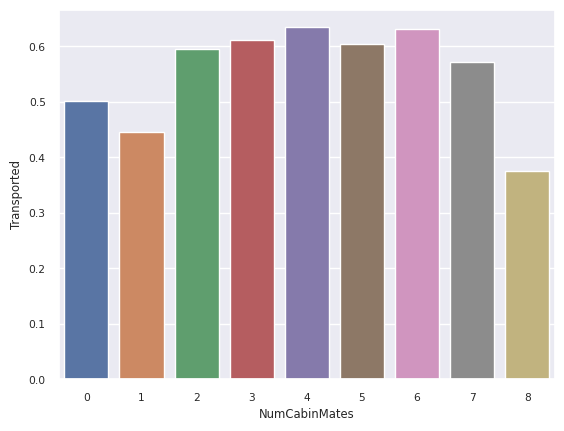

In [10]:
sns.barplot(x='NumCabinMates', y='Transported', data=train, errorbar=None)

## HomePlanet vs Transported
Пассажиры с планеты Europa имеют бОльшие шансы на транспортировку, чем остальные.

In [11]:
train.HomePlanet.value_counts()

HomePlanet
1    4803
2    2131
3    1759
Name: count, dtype: int64

In [12]:
train.groupby('HomePlanet').Transported.value_counts()

HomePlanet  Transported
1           False          2749
            True           2054
2           True           1404
            False           727
3           True            920
            False           839
Name: count, dtype: int64

In [13]:
train[['HomePlanet', 'Transported']].groupby('HomePlanet', as_index = False).mean()

,HomePlanet,Transported
0,1,0.427649
1,2,0.658846
2,3,0.523024


/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='HomePlanet', ylabel='Transported'>

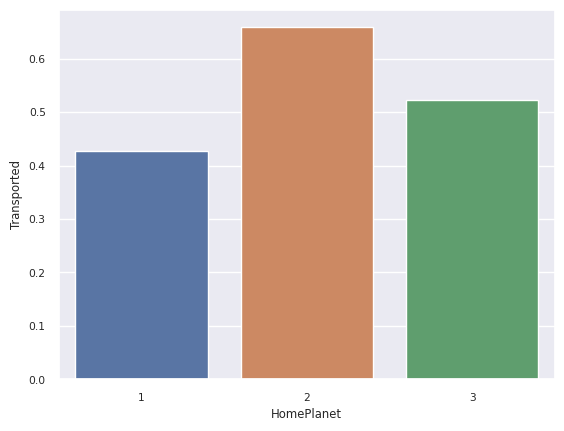

In [14]:
sns.barplot(x='HomePlanet', y='Transported', data=train, errorbar=None)

## Destination vs Transported
Влияния у этой фичи мало, но пассажиры, летящие в *55 Cancri e* имеют чуть большую вероятность транспортировки.

In [15]:
train.Destination.value_counts()

Destination
1    6097
2    1800
3     796
Name: count, dtype: int64

In [16]:
train.groupby('Destination').Transported.value_counts()

Destination  Transported
1            False          3218
             True           2879
2            True           1098
             False           702
3            True            401
             False           395
Name: count, dtype: int64

In [17]:
train[['Destination', 'Transported']].groupby('Destination', as_index = False).mean()

,Destination,Transported
0,1,0.472199
1,2,0.610000
2,3,0.503769


/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Destination', ylabel='Transported'>

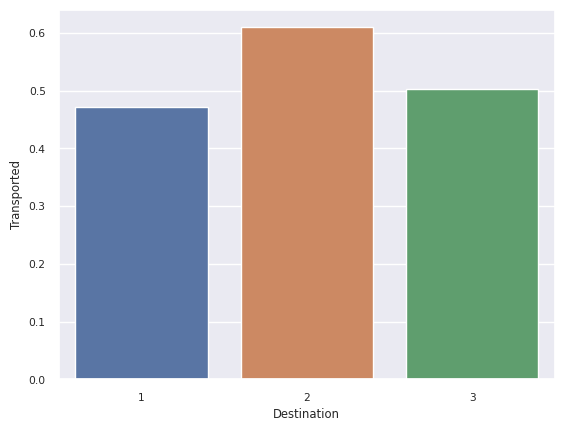

In [18]:
sns.barplot(x='Destination', y='Transported', data=train, errorbar=None)

## Age vs Transported

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

<Axes: xlabel='Destination', ylabel='Age'>

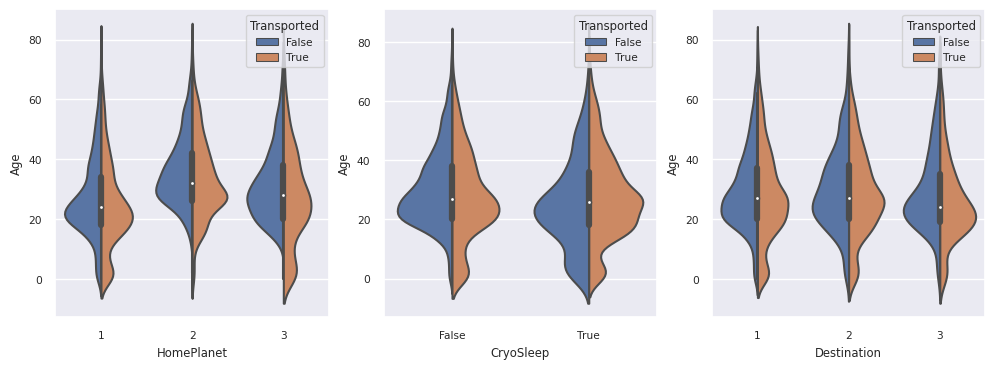

In [19]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)


sns.violinplot(x="HomePlanet", y="Age", hue="Transported", data=train, split=True, ax=ax1)
sns.violinplot(x="CryoSleep", y="Age", hue="Transported", data=train, split=True, ax=ax2)
sns.violinplot(x="Destination", y="Age", hue="Transported", data=train, split=True, ax=ax3)

* С Земли были транспортировано чуть больше детей, чем не транспортировано
* С Европы почти не было детей на борту, а те, что были - транспортированы
* С Марса были транспортированы все дети до 10 лет

* Дети, которые не были в анабиозе, преимущественно были транспортированы, а взрослые, наоборот, были транспортированы в чуть меньшем кол-ве
* Дети, которые были в анабиозе, в меньшем кол-ве были танспортированы, а взрослые в большем

* Пункт назначения по возрасту дает мало информации, графики схожи

## Deck vs Transported

In [20]:
train.Deck.value_counts()

Deck
6    2993
7    2559
5     876
2     779
3     747
4     478
1     256
8       5
Name: count, dtype: int64

In [21]:
train.groupby('Deck').Transported.value_counts()

Deck  Transported
1     False           129
      True            127
2     True            572
      False           207
3     True            508
      False           239
4     False           271
      True            207
5     False           563
      True            313
6     False          1664
      True           1329
7     True           1321
      False          1238
8     False             4
      True              1
Name: count, dtype: int64

In [22]:
train[['Deck', 'Transported']].groupby('Deck', as_index = False).mean()

,Deck,Transported
0,1,0.496094
1,2,0.734275
2,3,0.680054
3,4,0.433054
4,5,0.357306
5,6,0.444036
6,7,0.516217
7,8,0.200000


/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Deck', ylabel='Transported'>

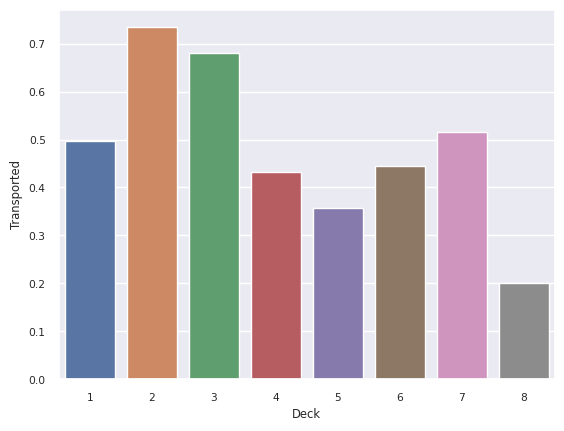

In [23]:
sns.barplot(x='Deck', y='Transported', data=train, errorbar=None)

## Side vs Transported
пассажиры, зашедшие с борта имеют чуть большие шансы на транспортировку, чем зашедшие с порта

In [24]:
train.Side.value_counts()

Side
1    4487
2    4206
Name: count, dtype: int64

In [25]:
train[['Side', 'Transported']].groupby('Side', as_index = False).mean()

,Side,Transported
0,1,0.552708
1,2,0.451260


/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Side', ylabel='Transported'>

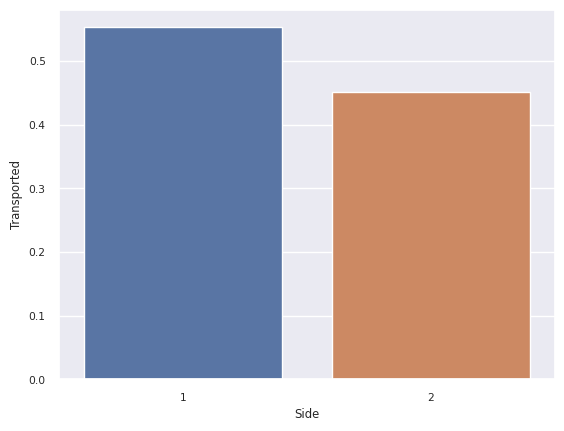

In [26]:
sns.barplot(x='Side', y='Transported', data=train, errorbar=None)

# Feature importance by Logistic Regression

In [27]:
def feature_importances(df):
        
    X = df.drop('Transported', axis=1)
    y = df[['Transported']]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
    
    # Logistic Regression    
    clf_lr = LogisticRegression(random_state = 0)
    clf_lr.fit(X_train, y_train)
    coef_lr = clf_lr.coef_[0]
    
    acc_train_lr = accuracy_score(y_true=y_train, y_pred=clf_lr.predict(X_train))
    acc_test_lr = accuracy_score(y_true=y_test, y_pred=clf_lr.predict(X_test))
    label_lr = f'Importance (LR abs), acc_train = {acc_train_lr:.2%}, acc_test = {acc_test_lr:.2%}'
    
    
    # Random Forest
    clf_rf = RandomForestClassifier(random_state = 0)
    clf_rf.fit(X_train, y_train)
    coef_rf = clf_rf.feature_importances_
    
    acc_train_rf = accuracy_score(y_true=y_train, y_pred=clf_rf.predict(X_train))
    acc_test_rf = accuracy_score(y_true=y_test, y_pred=clf_rf.predict(X_test))
    label_rf = f'Importance (LR abs), acc_train = {acc_train_rf:.2%}, acc_test = {acc_test_rf:.2%}'
    
    # CatBoost
    clf_cat = CatBoostClassifier(random_state = 0)
    clf_cat.fit(X_train, y_train, silent = True)
    coef_cat = clf_cat.feature_importances_
    
    acc_train_cat = accuracy_score(y_true=y_train, y_pred=clf_cat.predict(X_train).astype(bool))
    acc_test_cat = accuracy_score(y_true=y_test, y_pred=clf_cat.predict(X_test).astype(bool))
    label_cat = f'Importance (LR abs), acc_train = {acc_train_cat:.2%}, acc_test = {acc_test_cat:.2%}'

    print(acc_train_lr, acc_train_rf, acc_train_cat)
    print(acc_test_lr, acc_test_rf, acc_test_cat)
    
    feauture_importances = pd.DataFrame({
        'Feature': X.columns,
        'LR': np.abs(coef_lr),
        'RF': coef_rf,
        'CatBoost': coef_cat
    })
    
    feauture_importances = feauture_importances.sort_values(by = 'CatBoost', ascending=False)
    
    sc = MaxAbsScaler()
    feauture_importances[['LR', 'RF', 'CatBoost']] = sc.fit_transform(feauture_importances[['LR', 'RF', 'CatBoost']])
    
    # Plot everything
    
    feauture_importances.plot(kind='bar', x='Feature')
    
#     ax = plt.bar(x=feauture_importances['Feature'], height=feauture_importances['Importance (LR abs)'], label = label_lr)
#     plt.bar(x=feauture_importances['Feature'], height=feauture_importances['Importance (RF)'], label = label_rf, axes=ax)
#     plt.bar(x=feauture_importances['Feature'], height=feauture_importances['Importance (Cat)'], label = label_cat, axes=ax)
#     plt.show()
    

/home/neechan/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/home/neechan/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/neechan/miniconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.778340236232551 0.9998466022396073 0.503298051848443
0.7746090156393745 0.7953081876724931 0.5045998160073597


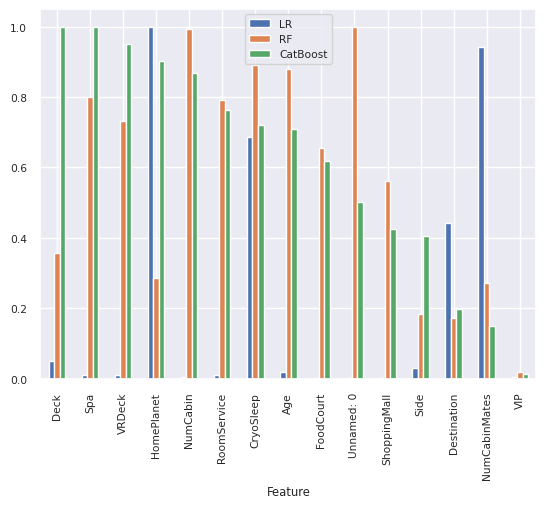

In [28]:
feature_importances(train)

<Axes: >

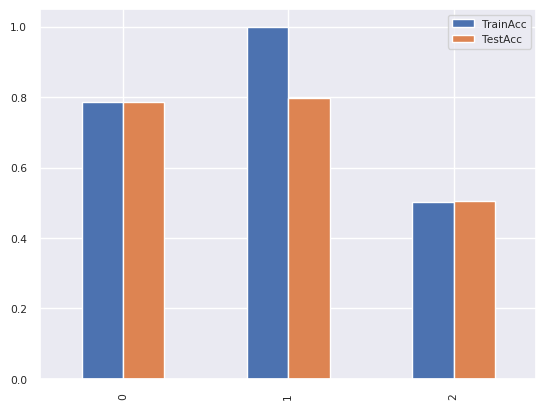

In [29]:
d = {
    'TrainAcc': [0.7850897376898297, 0.9993864089584292, 0.503298051848443],
    'TestAcc': [0.7865685372585096, 0.7989880404783809, 0.5045998160073597]
}
df_acc = pd.DataFrame(data=d)
df_acc.plot.bar()